In [1]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib

matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

In [2]:
df = pd.read_csv("temperature.csv")
portland = df[["datetime","Portland"]]
portland["datetime"] = pd.to_datetime(portland['datetime'])
portland.drop([0], inplace=True)
portland = portland.set_index('datetime')
y = portland["Portland"].resample("MS").mean()

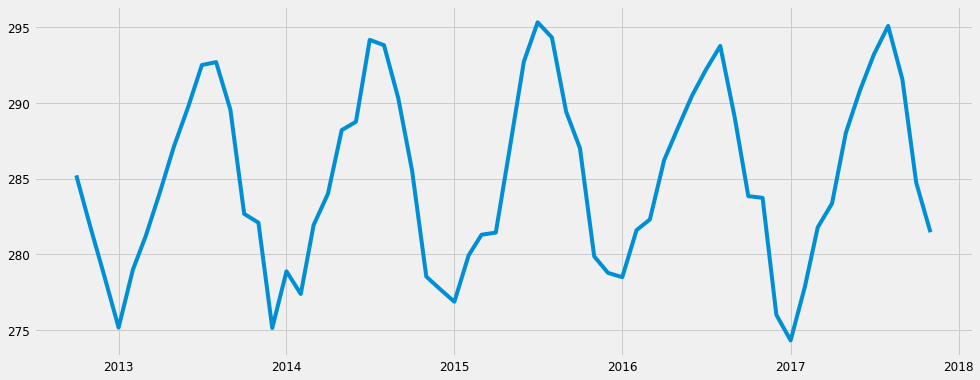

In [3]:
plt.figure(figsize=(15, 6))
plt.plot(y)

In [4]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [5]:
# for param in pdq:
#     for param_seasonal in seasonal_pdq:
#         try:
#             mod = sm.tsa.statespace.SARIMAX(y[:-12],
#                                             order=param,
#                                             seasonal_order=param_seasonal,
#                                             enforce_stationarity=False,
#                                             enforce_invertibility=False)

#             results = mod.fit()

#             print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
#         except:
#             continue

In [6]:
mod = sm.tsa.statespace.SARIMAX(y[:-12],
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

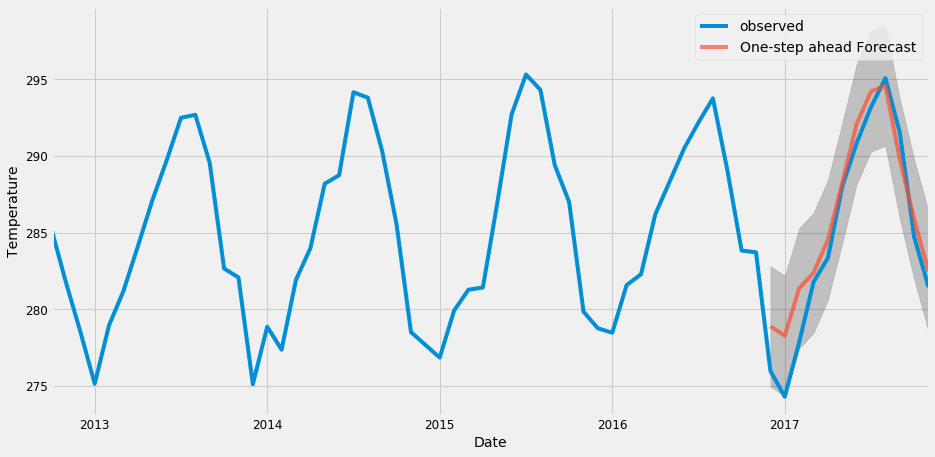

In [7]:
pred = results.get_forecast(steps=12)
pred_ci = pred.conf_int()

ax = y.plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Temperature')
plt.legend()

plt.show()

In [8]:
y_forecasted = pred.predicted_mean
y_truth = y['2016-11-01':]

mse = ((y_forecasted - y_truth) ** 2).mean()
mape = np.mean(np.abs((y_truth - y_forecasted) / y_truth)) * 100
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))
print('The Mean absolute percentage error of our forecasts is {}'.format(round(mape, 2)))

The Mean Squared Error of our forecasts is 3.89
The Root Mean Squared Error of our forecasts is 1.97
The Mean absolute percentage error of our forecasts is 0.57


In [9]:
temperature_data = pd.DataFrame({'ds':y.index, 'y':y.values})

In [10]:
from fbprophet import Prophet

ERROR:fbprophet:Importing plotly failed. Interactive plots will not work.


In [11]:
prophet_model = Prophet(interval_width=0.95)
prophet_model.fit(temperature_data[:-12])

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [12]:
temperature_forecast = prophet_model.make_future_dataframe(periods=12, freq='MS')
temperature_forecast = prophet_model.predict(temperature_forecast)

In [13]:
y_forecasted = temperature_forecast['yhat'].values[-12:]
y_truth = y['2016-12-01':]

mse = ((y_forecasted - y_truth) ** 2).mean()
mape = np.mean(np.abs((y_truth - y_forecasted) / y_truth)) * 100
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))
print('The Mean absolute percentage error of our forecasts is {}'.format(round(mape, 2)))

The Mean Squared Error of our forecasts is 1.76
The Root Mean Squared Error of our forecasts is 1.33
The Mean absolute percentage error of our forecasts is 0.39


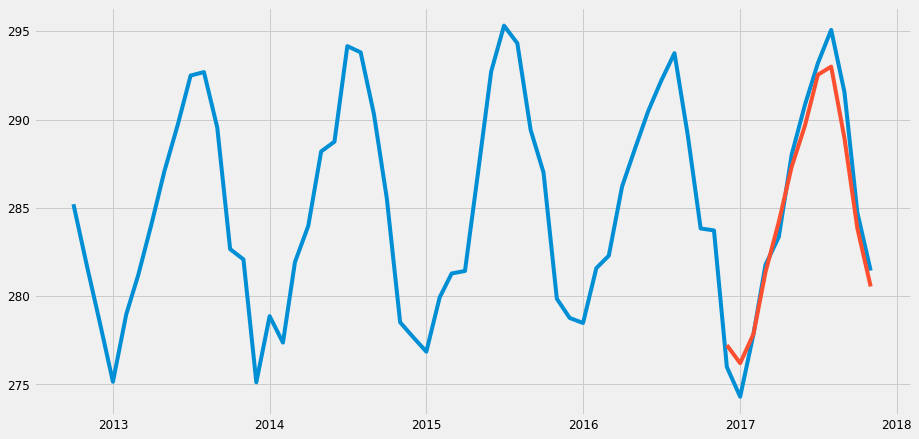

In [14]:
plt.figure(figsize=(14, 7))
plt.plot(temperature_data.set_index('ds'))
plt.plot(temperature_forecast[["ds", "yhat"]][-12:].set_index('ds'))
plt.show()